Load all necessary imports

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt
import h5py

# Configure Keras to use GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

2024-04-12 13:59:04.095120: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16308 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


Data Loading

In [3]:
with h5py.File('TrainingData5zeroes.h5', 'r') as hdf:
    ls = list(hdf.keys())
    images = hdf.get('images')
    boxes = hdf.get('boxes')
    images = np.array(images)
    boxes = np.array(boxes)

Data Normalization

In [4]:
image_normalized = (images+1)/9.26 # Normalize images and add noise


# Normalize bounding boxes
normalized_boxes = boxes / [1,64,64,64,64]

Model Train


In [5]:
from tensorflow.keras import layers, models



input_shape = (64, 64, 1)
num_classes = 280
num_coordinates = 4

images_np = image_normalized
#images_np = tf.expand_dims(images_np, axis=-1)
probabilities = np.array(normalized_boxes[:, :,:-4])
probabilities = tf.expand_dims(probabilities, axis=1)
boxes_np = np.array(normalized_boxes[:, :, 1:])
boxes_np = tf.expand_dims(boxes_np, axis=1)

dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))

dataset = dataset.batch(512)
dataset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True) 

x_input = layers.Input(shape=input_shape)

x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 

x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)  

x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)  # size: 32x32

x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)  # size: 32x32

x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)  # size: 16x16

x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)  # size: 16x16

x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) # size: 8x8x

x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) # size: 8x8x

x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) # size: 8x8x

x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) # size: 8x8x


x = layers.Flatten()(x)
# Bounding box output
x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob')(x)
x_prob_reshape = layers.Reshape((-1, num_classes, 1), name='x_prob_reshape')(x_prob)

x_boxes = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_boxes')(x)
x_boxes_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_boxes_reshape')(x_boxes)


model = tf.keras.models.Model(x_input, [x_prob_reshape, x_boxes_reshape])


optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)  # Consider adjusting based on performance





model.compile(optimizer= optimizer, loss= {'x_prob_reshape': tf.keras.losses.BinaryCrossentropy(), 'x_boxes_reshape':tf.keras.losses.MeanSquaredError()}, metrics={'x_prob_reshape': 'accuracy'} )
num_epochs = 2000


2024-04-12 13:59:17.455435: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16308 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


In [19]:
# model.fit(dataset, epochs=num_epochs)

In [20]:
# model.save('model5zeroes18000epochs.h5')



In [21]:
loaded_model = tf.keras.models.load_model("/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/M11overfittedmodel3variant.h5")


In [39]:
dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))
dataset = dataset.batch(1000)
#dataset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True) 
inputs,targets = next(iter(dataset))
output = loaded_model.predict(inputs)

32/32 [==============================] - 0s 8ms/step


In [8]:
import tensorflow as tf

r = np.random.randint(0,100)
tensor1 = tf.constant(targets['x_prob_reshape'], dtype=tf.float64)

tensor2 = tf.constant(output[0], dtype=tf.float32)


tensor2 = tf.cast(tensor2, tf.float64)


mse_loss_fn =  tf.keras.losses.BinaryCrossentropy()
mse_loss = mse_loss_fn(tensor1, tensor2)

print("MSE Loss:", mse_loss.numpy())


MSE Loss: 6.741875542396553e-08


In [61]:
import tensorflow as tf
import numpy as np
import h5py
from sklearn.metrics import mean_absolute_error, precision_score, recall_score

def load_model(model_path):
    return tf.keras.models.load_model(model_path)

def preprocess_data(images, boxes):
    # Normalizing the pixel values
    processed_images = (images + 1) / 9.26  # Adjust based on your normalization needs
    # Normalize bounding boxes
    normalized_boxes = boxes / [1, 64, 64, 64, 64]  # Assuming boxes need to be normalized similarly
    return processed_images, normalized_boxes

def predict(model, test_images):
    predictions = model.predict(test_images)
    # Ensure predictions are a numpy array, regardless of initial format
    predictions = np.array(predictions)
    # Check if predictions are still nested or have an incorrect shape
    if predictions.ndim > 2:
        # This assumes predictions need to be flattened or reshaped
        predictions = predictions.reshape(predictions.shape[0], -1)
    return predictions


# def predict(model, test_images):
#     predictions = model.predict(test_images)
#     # Ensure predictions are numpy array for further processing
#     predictions = np.array(predictions).squeeze()  # Adjust depending on the model's output shape
#     return predictions


# def calculate_metrics(predictions, ground_truth):
#     # Convert probabilities to binary predictions
#     predicted_labels = (predictions > 0.5).astype(int)
#     mae = mean_absolute_error(ground_truth, predicted_labels)
#     precision = precision_score(ground_truth, predicted_labels, average='macro')
#     recall = recall_score(ground_truth, predicted_labels, average='macro')
#     return mae, precision, recall

def calculate_metrics(predictions, ground_truth):
    # Ensure predictions are suitable for comparison
    # Example check: Convert probabilities to binary predictions if necessary
    if predictions.ndim == 2 and predictions.shape[1] == 1:
        # If predictions are probabilities for a binary classification
        predicted_labels = (predictions > 0.5).astype(int).flatten()
    elif predictions.ndim == 2 and predictions.shape[1] > 1:
        # If predictions are probabilities for multi-class classification
        predicted_labels = np.argmax(predictions, axis=1)
    else:
        # If predictions are already binary or integer labels
        predicted_labels = predictions.astype(int)

    # Calculate metrics, ensuring ground_truth is compatible
    mae = mean_absolute_error(ground_truth.flatten(), predicted_labels)
    precision = precision_score(ground_truth.flatten(), predicted_labels, average='macro', zero_division=0)
    recall = recall_score(ground_truth.flatten(), predicted_labels, average='macro', zero_division=0)
    return mae, precision, recall



def load_test_data(file_path):
    with h5py.File(file_path, 'r') as hdf:
        images = np.array(hdf['images'])
        boxes = np.array(hdf['boxes'])
    return images, boxes

def save_results(mae, precision, recall, file_path):
    np.savez(file_path, mae=mae, precision=precision, recall=recall)

def main():
    model_path = "/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/M11overfittedmodel3variant.h5"
    file_path = 'TrainingData5zeroes.h5'
    
    images, boxes = load_test_data(file_path)
    processed_images, normalized_boxes = preprocess_data(images, boxes)
    
    model = load_model(model_path)
    predictions = predict(model, processed_images)
    
    mae, precision, recall = calculate_metrics(predictions, normalized_boxes)
    save_results(mae, precision, recall, 'evaluation_results.npz')
    
    print("Evaluation completed. Results saved.")

if __name__ == "__main__":
    main()


313/313 [==============================] - 3s 8ms/step


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 4 dimensions. The detected shape was (2, 10000, 1, 280) + inhomogeneous part.

In [62]:
output[0].shape,output[1].shape

((1000, 1, 280, 1), (1000, 1, 280, 4))

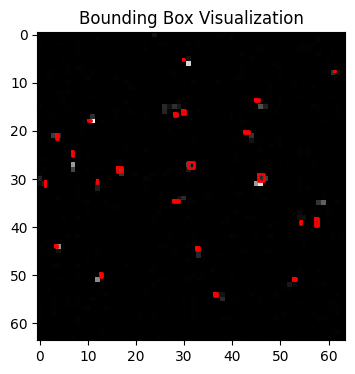

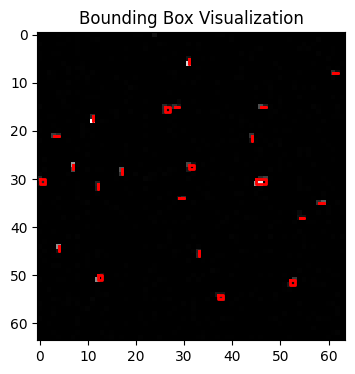

In [14]:
def visualize_bounding_boxes(image, probability_vector, bounding_box_coordinates, threshold=0.9):
    """
    Visualizes bounding boxes on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with bounding boxes.
    - bounding_box_coordinates: A 2D tensor representing bounding box coordinates.
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with bounding boxes).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    bbox_coordinates_np = bounding_box_coordinates
   # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Bounding Box Visualization")

    # Plot bounding boxes based on probability threshold
    for i in range(len(prob_vector_np)):
        prob = prob_vector_np[i]
        bbox = bbox_coordinates_np[i]
        if prob > threshold:
            # Denormalize bounding box coordinates if necessary
            denormalized_bbox = bbox  # Modify if normalization was applied during training
            y1, x1, y2, x2 = denormalized_bbox
            plt.plot([x1, x2, x2, x1, x1],[y1, y1, y2, y2, y1],
                     
                     color='r', linewidth=2, label='Bounding Box')

   






   
    plt.show()

t = np.random.randint(0,1100)


visualize_bounding_boxes(tf.convert_to_tensor(inputs[t]), probabilities.numpy()[t].squeeze(), tf.convert_to_tensor(output[1][t,0,:,:])*[64,64,64,64]) ##myprediction
visualize_bounding_boxes(tf.convert_to_tensor(image_normalized[t]), probabilities.numpy()[t].squeeze(), tf.convert_to_tensor(boxes_np[t,0,:,:])*[64,64,64,64]) ##myprediction



